In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.core.pybullet_core import PybulletCore
from src.utils import *

# Open Pybullet GUI

In [25]:
pb = PybulletCore()
pb.connect(robot_name = "indy7_v2", joint_limit=True, constraint_visualization = False)

******** ROBOT INFO ********
Robot name: indy7_v2
Robot type: indy7_v2
DOF: 6
Joint limit: True
Constraint visualization: False


Exception in thread Thread-13:
Traceback (most recent call last):
  File "c:\Users\rnbmarch\AppData\Local\anaconda3\envs\robotics\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rnbmarch\AppData\Local\anaconda3\envs\robotics\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\rnbmarch\AppData\Local\anaconda3\envs\robotics\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rnbmarch\OneDrive - postech.ac.kr\바탕 화면\robotics\mech439_pybullet_framework-main\src\core\pybullet_core.py", line 123, in _thread_main
    self.my_robot.robot_update()
  File "c:\Users\rnbmarch\OneDrive - postech.ac.kr\바탕 화면\robotics\mech439_pybullet_framework-main\src\core\pybullet_robot.py", line 57, in robot_update
    self._get_robot_states()      # update robot's states
  File "c:\Users\rnbmarch\OneDrive - postech.ac.kr\바탕 화면\robotics\mech439_pybullet_framework-main\src\

# Move robot

In [26]:
pb.MoveRobot([0, 30, -120, 0, -90, 0], degree=True, verbose=True)
from time import sleep
sleep(3)

***** Set desired joint angle *****
[ 0.      0.5236 -2.0944  0.     -1.5708  0.    ]


## IK using XYZ position and ZYZ Euler angle

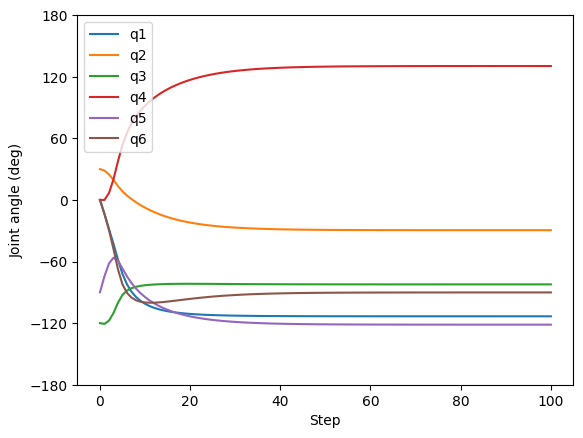

In [5]:
T_goal = xyzeul2SE3([0, -0.5, 0.5], [0,45,0], seq='ZYZ', degree=True)

trajectories = [T_goal]

pb.add_debug_frames([T_goal])

q_i = pb.my_robot.q
qlist = np.zeros([6, 0])
qlist = np.concatenate((qlist, q_i), axis=1)
for _ in range(100):
    T_i = pb.my_robot.pinModel.FK(q_i)

    trajectories.append(T_i)
    pb.add_debug_frames(trajectories)

    Jb_i = pb.my_robot.pinModel.Jb(q_i)

    R_i = T_i[0:3, 0:3]
    A_upper = np.concatenate((np.zeros([3, 3]), R_i), axis=1)
    A_lower = np.concatenate((np.eye(3), np.zeros([3, 3])), axis=1)
    A = np.concatenate((A_upper, A_lower), axis=0)

    Jv_i = A @ Jb_i
    
    r_err = T_goal[0:3, [3]] - T_i[0:3, [3]]

    # ==== IK using euler angle ====
    R_err = T_i[0:3, 0:3].T @ T_goal[0:3, 0:3]
    xi_err = Rot2Vec(R_err)
    p_err = np.concatenate((r_err, xi_err), axis=0)
 
    q_i = q_i + 0.1*np.linalg.pinv(Jv_i) @ p_err


    qlist = np.concatenate((qlist, q_i), axis=1)
    pb.MoveRobot(q_i, degree=False)
    sleep(0.1)

import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(qlist.T*180/np.pi)
plt.legend(["q1", "q2", "q3", "q4", "q5", "q6"])
plt.xlabel("Step")
plt.ylabel("Joint angle (deg)")
plt.yticks([-180, -120, -60, 0, 60, 120, 180])
plt.show()

## Position, Orientation Coupled path

In [36]:
pb.MoveRobot([0, 30, -120, 0, -90, 0], degree=True, verbose=True)
from time import sleep
sleep(1)
q_i = pb.my_robot.q
pb.add_debug_frames([pb.my_robot.pinModel.FK(q_i)])

***** Set desired joint angle *****
[ 0.      0.5236 -2.0944  0.     -1.5708  0.    ]


In [37]:
num_points = 1000

q_i = pb.my_robot.q

q_i = pb.my_robot.q
qlist = np.zeros([6, 0])
qlist = np.concatenate((qlist, q_i), axis=1)


T_start = pb.my_robot.pinModel.FK(q_i)
T_end = xyzeul2SE3([0, -0.5, 0.5], [0,45,0], seq='ZYZ', degree=True)

trajectories = [T_end]

pb.add_debug_frames([T_end])

for i in range(num_points+1):
    T_goal = T_start @ Vec2SE3( SE32Vec( TransInv(T_start) @ T_end) * (i/num_points) )
    
    if i%50 == 0:
        trajectories.append(T_goal)
        pb.add_debug_frames(trajectories)


    T_i = pb.my_robot.pinModel.FK(q_i)
    Jb_i = pb.my_robot.pinModel.Jb(q_i)
    
    R_i = T_i[0:3, 0:3]
    A_upper = np.concatenate((np.zeros([3, 3]), R_i), axis=1)
    A_lower = np.concatenate((np.eye(3), np.zeros([3, 3])), axis=1)
    A = np.concatenate((A_upper, A_lower), axis=0)

    Jv_i = A @ Jb_i
    
    r_err = T_goal[0:3, [3]] - T_i[0:3, [3]]
    
    # ==== IK using exponential coordinate ====
    R_err = T_i[0:3, 0:3].T @ T_goal[0:3, 0:3]
    xi_err = Rot2Vec(R_err)
    p_err = np.concatenate((r_err, xi_err), axis=0)
    
    q_i = q_i + 1*np.linalg.pinv(Jv_i) @ p_err

    qlist = np.concatenate((qlist, q_i), axis=1)
    pb.MoveRobot(q_i, degree=False)
    sleep(5/num_points)


## Position, Orientation Decoupled path

In [38]:
pb.MoveRobot([0, 30, -120, 0, -90, 0], degree=True, verbose=True)
from time import sleep
sleep(1)
q_i = pb.my_robot.q
pb.add_debug_frames([pb.my_robot.pinModel.FK(q_i)])

***** Set desired joint angle *****
[ 0.      0.5236 -2.0944  0.     -1.5708  0.    ]


In [39]:
num_points = 1000

q_i = pb.my_robot.q
q_i = pb.my_robot.q
qlist = np.zeros([6, 0])
qlist = np.concatenate((qlist, q_i), axis=1)
T_start = pb.my_robot.pinModel.FK(q_i)
T_end = xyzeul2SE3([0, -0.5, 0.5], [0,45,0], seq='ZYZ', degree=True)

trajectories = [T_end]

pb.add_debug_frames([T_end])

p_start = T_start[0:3, [3]]
p_end = T_end[0:3, [3]]

R_start = T_start[0:3, 0:3]
R_end = T_end[0:3, 0:3]


for i in range(num_points+1):
    
    p_goal = p_start + (i/num_points) * (p_end - p_start)
    R_goal = R_start @ Vec2Rot( Rot2Vec( R_start.T @ R_end ) * (i/num_points) )

    T_goal = np.eye(4)
    T_goal[0:3, [3]] = p_goal
    T_goal[0:3, 0:3] = R_goal

    if i%50 == 0:
        trajectories.append(T_goal)
        pb.add_debug_frames(trajectories)


    T_i = pb.my_robot.pinModel.FK(q_i)
    Jb_i = pb.my_robot.pinModel.Jb(q_i)
    
    R_i = T_i[0:3, 0:3]
    A_upper = np.concatenate((np.zeros([3, 3]), R_i), axis=1)
    A_lower = np.concatenate((np.eye(3), np.zeros([3, 3])), axis=1)
    A = np.concatenate((A_upper, A_lower), axis=0)

    Jv_i = A @ Jb_i
    
    r_err = T_goal[0:3, [3]] - T_i[0:3, [3]]
    
    # ==== IK using exponential coordinate ====
    R_err = T_i[0:3, 0:3].T @ T_goal[0:3, 0:3]
    xi_err = Rot2Vec(R_err)
    p_err = np.concatenate((r_err, xi_err), axis=0)
    
    q_i = q_i + 1*np.linalg.pinv(Jv_i) @ p_err

    qlist = np.concatenate((qlist, q_i), axis=1)
    pb.MoveRobot(q_i, degree=False)
    sleep(5/num_points)


## With time scaling

In [42]:
pb.MoveRobot([0, 30, -120, 0, -90, 0], degree=True, verbose=True)
from time import sleep
sleep(1)
q_i = pb.my_robot.q
pb.add_debug_frames([pb.my_robot.pinModel.FK(q_i)])

***** Set desired joint angle *****
[ 0.      0.5236 -2.0944  0.     -1.5708  0.    ]


In [43]:
num_points = 30
T = 5

a = np.linalg.solve([[1, 0, 0, 0],
                     [1, T, T**2, T**3],
                     [0, 1, 0, 0],
                     [0, 1, 2*T, 3*T**2]],
                     [0, 1, 0, 0])

q_i = pb.my_robot.q
q_i = pb.my_robot.q
qlist = np.zeros([6, 0])
qlist = np.concatenate((qlist, q_i), axis=1)
T_start = pb.my_robot.pinModel.FK(q_i)
T_end = xyzeul2SE3([0, -0.5, 0.5], [0,45,0], seq='ZYZ', degree=True)

trajectories = [T_end]

pb.add_debug_frames([T_end])

p_start = T_start[0:3, [3]]
p_end = T_end[0:3, [3]]

R_start = T_start[0:3, 0:3]
R_end = T_end[0:3, 0:3]


for i in range(num_points):

    t = T * i / num_points

    s = np.dot(a, [1, t, t**2, t**3])
    
    p_goal = p_start + s * (p_end - p_start)
    R_goal = R_start @ Vec2Rot( Rot2Vec( R_start.T @ R_end ) * s )

    T_goal = np.eye(4)
    T_goal[0:3, [3]] = p_goal
    T_goal[0:3, 0:3] = R_goal

    if i%50 == 0:
        trajectories.append(T_goal)
        pb.add_debug_frames(trajectories)


    T_i = pb.my_robot.pinModel.FK(q_i)
    Jb_i = pb.my_robot.pinModel.Jb(q_i)
    
    R_i = T_i[0:3, 0:3]
    A_upper = np.concatenate((np.zeros([3, 3]), R_i), axis=1)
    A_lower = np.concatenate((np.eye(3), np.zeros([3, 3])), axis=1)
    A = np.concatenate((A_upper, A_lower), axis=0)

    Jv_i = A @ Jb_i
    
    r_err = T_goal[0:3, [3]] - T_i[0:3, [3]]
    
    # ==== IK using exponential coordinate ====
    R_err = T_i[0:3, 0:3].T @ T_goal[0:3, 0:3]
    xi_err = Rot2Vec(R_err)
    p_err = np.concatenate((r_err, xi_err), axis=0)
    
    q_i = q_i + 1*np.linalg.pinv(Jv_i) @ p_err

    qlist = np.concatenate((qlist, q_i), axis=1)
    pb.MoveRobot(q_i, degree=False)
    sleep(T/num_points)
